In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from subprocess import check_output
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow import keras

In [2]:
df = pd.read_csv("/content/rainfaLLIndia-2.csv")

In [ ]:
df[['JUN', 'JUL', 'AUG', 'SEP']].plot(figsize=(18,6))


In [ ]:
df.head(50)


Getting Rid of negative Values as they will fuck up the model

In [3]:
df2 = df.loc[(df["JUN"] >= 0) & (df["JUL"] >= 0) & (df["AUG"] >= 0) & (df["SEP"] >= 0)]
df2.reset_index(drop = True, inplace = True)

Converting df["YEAR"] into DateTime Format

In [ ]:
# i = 0
# for i in range(df['YEAR'].size):
#     df['YEAR'][i] = datetime(df['YEAR'][i], 1, 1) # Set the month and day to arbitrary values
#     i =+ 1

# df.head()

decomposing different parts of the time series

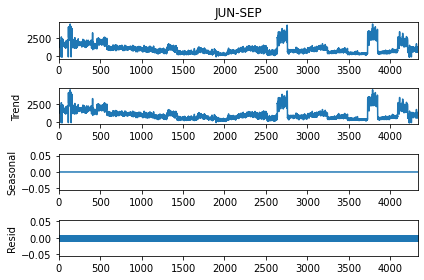

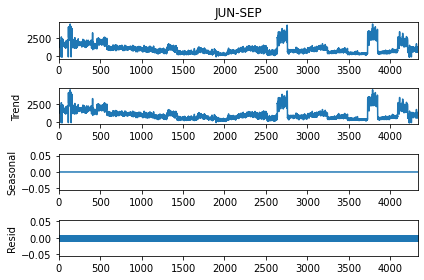

In [4]:
results = seasonal_decompose(df["JUN-SEP"], period=1)
results.plot()

Separating Data into Training set and Test Set

In [5]:
X = df['YEAR'].values
y = df['JUN-SEP'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = [X_train, y_train]
train_set = pd.DataFrame([y_train, X_train])
train_set



,0,1,2,3,4,5,6,7,8,9,...,3455,3456,3457,3458,3459,3460,3461,3462,3463,3464
0,861.3,959.7,1539.5,1716.5,424.2,1139.7,997.0,493.0,835.9,2581.9,...,1170.0,854.8,2789.5,524.2,1239.9,749.4,2001.1,796.1,2908.7,1125.7
1,2013.0,1954.0,1924.0,1945.0,2013.0,1913.0,2021.0,1973.0,2002.0,1933.0,...,1967.0,1915.0,1930.0,1939.0,1949.0,1980.0,1906.0,1991.0,1945.0,1937.0


Preprocessing Data Using MinMaxScaler 

In [6]:
scaler = StandardScaler()
X_train_reshaped = np.reshape(X_train, (-1, 1))
X_train_scaled = scaler.fit_transform(X_train_reshaped)
y_train_scaled = scaler.transform(y_train.reshape(-1, 1))

X_test_reshaped = np.reshape(X_test, (-1, 1))
X_test_scaled = scaler.fit_transform(X_test_reshaped)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))


In [ ]:
X_train_scaled 

In [7]:
input_seq_len = 12
output_seq_len = 1

# Create the generator object
train_generator = keras.preprocessing.sequence.TimeseriesGenerator(X_train_scaled, y_train_scaled,
                                      length=input_seq_len, batch_size=1)

# Print the first batch of input and output sequences
x_train_batch, y_train_batch = train_generator[0]
print('Input sequence:', x_train_batch)
print('Output sequence:', y_train_batch)

Input sequence: [[[ 1.48339625]
  [-0.20261682]
  [-1.0599116 ]
  [-0.45980525]
  [ 1.48339625]
  [-1.37425302]
  [ 1.71200819]
  [ 0.34033654]
  [ 1.16905483]
  [-0.80272316]
  [-0.40265227]
  [-0.03115786]]]
Output sequence: [[-40.99556015]]


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [13]:
model = keras.Sequential()
model.add(LSTM(128, activation='relu', input_shape=(input_seq_len, output_seq_len), return_sequences=True))
model.add(Dropout(0.1))
model.add(Dense(16, activation='softmax'))
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 12, 128)           66560     
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 12, 16)            2064      
                                                                 
Total params: 68,624
Trainable params: 68,624
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(train_generator,epochs=15, batch_size = 8)

Epoch 1/15
3453/3453 [==============================] - 55s 9ms/step - loss: 1089.7626
Epoch 2/15
3453/3453 [==============================] - 31s 9ms/step - loss: 1089.7639
Epoch 3/15
3453/3453 [==============================] - 31s 9ms/step - loss: 1089.7629
Epoch 4/15
3453/3453 [==============================] - 30s 9ms/step - loss: 1089.7643
Epoch 5/15
3453/3453 [==============================] - 30s 9ms/step - loss: 1089.7646
Epoch 6/15
3453/3453 [==============================] - 31s 9ms/step - loss: 1089.7638
Epoch 7/15
3453/3453 [==============================] - 31s 9ms/step - loss: 1089.7645
Epoch 8/15
3453/3453 [==============================] - 34s 10ms/step - loss: 1089.7622
Epoch 9/15
3453/3453 [==============================] - 32s 9ms/step - loss: 1089.7633
Epoch 10/15
3453/3453 [==============================] - 31s 9ms/step - loss: 1089.7627
Epoch 11/15
3453/3453 [==============================] - 29s 8ms/step - loss: 1089.7637
Epoch 12/15
3453/3453 [=================

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_generator = keras.preprocessing.sequence.TimeseriesGenerator(X_test_scaled, y_test_scaled, length=input_seq_len, batch_size=batch_size)

# evaluate the model on test data
model.evaluate_generator(test_generator)

# make predictions on test data
predictions = model.predict_generator(test_generator)

# inverse transform the scaled data to get the actual values
# predictions = scaler.inverse_transform(predictions)
predictions = predictions.reshape(-1, input_seq_len)
test = scaler.inverse_transform(y_test_scaled)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))

plt.plot(y)
plt.plot(test)
plt.plot(predictions)
# pd.DataFrame(y).plot(figsize=(18,6))
# pd.DataFrame(y_train).plot(figsize=(18,6))
# pd.DataFrame(y_test).plot(figsize=(18,6))

In [ ]:
temp = y_test.size - predictions.size
y_test.size


In [ ]:
plt.scatter(X_test[:868], predictions)

In [ ]:
test_compare = pd.DataFrame({'True Values': y_test[:-(temp)].ravel(), 'Predicted Values': predictions.ravel()})

In [ ]:
test_compare

In [ ]:
test_compare.iloc[:50,:].plot(figsize=(14,5))